In [9]:
# Update all relevant packages with conda
!conda install statsmodels seaborn pandas scipy seaborn numpy matplotlib openpyxl plotly -y 

Channels:
 - defaults
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3/envs/ezpz_env

  added / updated specs:
    - matplotlib
    - numpy
    - openpyxl
    - pandas
    - plotly
    - scipy
    - seaborn
    - statsmodels


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    et_xmlfile-1.1.0           |   py38hca03da5_0          10 KB
    openpyxl-3.1.5             |   py38h80987f9_0         590 KB
    ------------------------------------------------------------
                                           Total:         600 KB

The following NEW packages will be INSTALLED:

  et_xmlfile         pkgs/main/osx-arm64::et_xmlfile-1.1.0-py38hca03da5_0 
  openpyxl           pkgs/main/osx-arm64::openpyxl-3.1.5-py38h80987f9_0 



openpyxl-3.1.5       | 590 KB    |                                       |   0% 
openpyxl-3.1.5       | 590 KB   

In [2]:
import sys
import pandas as pd
import numpy as np
import scipy.stats as ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.subplots as sp


In [3]:
print(sys.executable)

/opt/anaconda3/envs/ezpz_env/bin/python


In [4]:
# List the contents of the current directory
!ls
# Print the working directory
!pwd
# Check the Python version
!python --version


ezpz_analysis.ipynb
/Users/ecrespo/Documents/github_project_folder/ezpzmouseanalytics/notebooks
Python 3.8.19


# Import the data

In [ ]:
file_path_social = '/Users/ecrespo/Documents/github_project_folder/ezpzmouseanalytics/data/raw/Rbp4_social.csv' 
file_path_grooming = '/Users/ecrespo/Documents/github_project_folder/ezpzmouseanalytics/data/raw/Rbp4_grooming.csv'

In [10]:
# Define the function to consolidate multiple sheets into a single tidy CSV file
def excel_to_tidy_csv(file_path, output_path):
    # Load the Excel file
    excel_data = pd.ExcelFile(file_path)
    
    # Initialize a dictionary to store data from each non-empty sheet
    data_dict = {}

    # Loop through each sheet, check if it's non-empty, and load the data if so
    for sheet_name in excel_data.sheet_names:
        sheet_data = excel_data.parse(sheet_name)
        
        # Check if the sheet is non-empty by seeing if it has any non-NaN values
        if not sheet_data.dropna(how='all').empty:
            # Add to dictionary if sheet contains data
            data_dict[sheet_name] = sheet_data

    # Consolidate all non-empty sheets into a tidy DataFrame with cohort name as an identifier
    tidy_data = []
    
    for sheet_name, data in data_dict.items():
        # Drop entirely empty rows and columns for a cleaner format
        cleaned_data = data.dropna(how='all').dropna(axis=1, how='all')
        
        # Add cohort name as a column for easy identification
        cleaned_data['Cohort'] = sheet_name.strip()
        
        # Append to the list of dataframes
        tidy_data.append(cleaned_data)
    
    # Concatenate all dataframes in the list into one tidy DataFrame
    combined_df = pd.concat(tidy_data, ignore_index=True)
    
    # Save the tidy DataFrame to CSV
    combined_df.to_csv(output_path, index=False)
    
    return output_path

# File paths for the input and output
file_path = '/Users/ecrespo/Desktop/rbp4_novel_object/Rbp4 Novel Object analysis (day 2 + 3).xlsx'
output_path = '/Users/ecrespo/Documents/github_project_folder/ezpzmouseanalytics/data/processed/tidy_Rbp4_Novel_Object_analysis.csv'

# Run the function and generate the output CSV
result_path = excel_to_tidy_csv(file_path, output_path)
result_path

'/Users/ecrespo/Documents/github_project_folder/ezpzmouseanalytics/data/processed/tidy_Rbp4_Novel_Object_analysis.csv'

# Initialize the class 

In [6]:
class EzPzMouseAnalytics:
    def __init__(self, file_path):
        # Main class code
        """
        Initialize the EzPzMouseAnalytics object with the path to the CSV file containing the data.
        :param file_path: Path to the CSV file containing the data.
        
        """
        self.file_path = file_path
        """string: Path to the CSV file containing the data."""
        self.data = None
        """pandas.DataFrame: The main dataframe containing all mouse data after initial processing.""" 
        self.genotype_nested_df = None
        """pandas.DataFrame: Grouped dataframe where each group represents a unique genotype."""
        self.genotype_sex_groups = None
        """pandas.DataFrame: Grouped dataframe where each group represents a unique combination of genotype and sex."""
        self.genotype_colors = {
            'Rbp4-LMO3': 'hotpink',
            'wt-LMO3': 'grey'}
        """dict: Mapping of genotypes to their respective plot colors."""

        
        
        # Load and process data
        self.extract_data()  # Load the data
        self.rename_columns()  # Rename columns as needed
        self.calculate_age_in_months() # Calculate age in months and add to DataFrame
        self.check_unique_tags() # Check for duplicate tag entries 
        self._initialize_dataframes()  # Create grouped DataFrames after renaming
        

        # Initialize the classes neeed for analysis and plotting
     
        self.genotype_comparison = self.GenotypeComparisonAnalysis(self)
        """GenotypeComparisonAnalysis: Object for comparing two genotypes."""
        
        self.analysis = self.Analysis(self)
        """Analysis: Object for performing statistical analysis on the data."""   
    
    def _initialize_dataframes(self):
        """
        Internal method to initialize the genotype and genotype-sex separated DataFrames
        after loading the data. Intiliazed during the __init__ method.
        """
        if self.data is None:
            raise ValueError("Data not loaded. Please run extract_data() first.")

        # Create nested DataFrame for each genotype, dropping only the 'genotype' column
        self.genotype_nested_df = self.data.groupby('genotype').apply(
            lambda x: x.drop('genotype', axis=1)
        )

        # Create separate DataFrames for each combination of genotype and sex
        self.genotype_sex_groups = self.data.groupby(['genotype', 'sex']).apply(
            lambda x: x.drop(['genotype', 'sex'], axis=1)
        )
 
        #print("Columns in genotype_nested_df:", self.genotype_nested_df.columns.tolist())
        #print("Columns in genotype_sex_groups:", self.genotype_sex_groups.columns.tolist())

    def rename_columns(self):
        """
        Rename specific columns in the self.data based on the strings in the column_map dictionary. 
        Intialized during the __init__ method.
        
        """
        if self.data is None:
            raise ValueError("Data not loaded. Please run extract_data() first.")
        
        print("rename_columns method called.")
        print("Columns before renaming:", self.data.columns.tolist())
      
       #create a mapping of the new names 
        column_map = {
            'summouse1': 'interactiontime_sum_familiar',
            'summouse2': 'interactiontime_sum_stranger',
            'avgmouse1': 'interactiontime_avg_familiar',
            'avgmouse2': 'interactiontime_avg_stranger',
            'boutmouse1': 'approach_sum_familiar',
            'boutmouse2': 'approach_sum_stranger'
        }
        
        # Rename the column names that are in the column_map
        self.data.rename(columns=column_map, inplace=True)
        print("Columns after renaming:", self.data.columns.tolist())
    
    def extract_data(self):
        """
        
        Extract data from the CSV file and store it in a DataFrame. But remove the Unamed: 15 and Unamed: 16 columns
        
        :return: DataFrame containing the loaded data.
        """
        self.data = pd.read_csv(self.file_path)
        self.data = self.data.drop(columns=['Unnamed: 15', 'Unnamed: 16'])

        return self.data

    def calculate_age_in_months(self):
        """
        Calculate the age of each mouse at the time of testing in months.
        Intialized during the __init__ method.
        :return: DataFrame with columns for DOB, datetested, and age in months.
        """
        if self.data is None:
            raise ValueError("Data not loaded. Please run extract_data() first.")
        
        # Clean up any leading or trailing spaces in the column names
        self.data.columns = self.data.columns.str.strip()
        
        # Rename 'date tested' to 'datetested' if it exists
        if 'date tested' in self.data.columns:
            self.data.rename(columns={'date tested': 'datetested'}, inplace=True)
        else:
            raise KeyError("Column 'date tested' not found in the data. Please check the column names.")
        
        # Convert DOB and datetested to datetime objects
        self.data['DOB'] = pd.to_datetime(self.data['DOB'], format='%m/%d/%y')
        self.data['datetested'] = pd.to_datetime(self.data['datetested'], format='%m/%d/%y')
        
        # Calculate the difference in months
        self.data['age_in_months'] = ((self.data['datetested'] - self.data['DOB']).dt.days / 30.44).round(2)
        return self.data[['DOB', 'datetested', 'age_in_months']]

    def check_unique_tags(self):
        """
        Ensure that the 'tag' column contains unique identifiers for each mouse.
        
        :return: DataFrame with duplicate tag entries if any exist; otherwise, None.
        """
        if self.data is None:
            raise ValueError("Data not loaded. Please run extract_data() first.")
        
        duplicate_tags = self.data[self.data.duplicated('tag', keep=False)]
        
        if not duplicate_tags.empty:
            print("Duplicate 'tag' values found.")
            return duplicate_tags[['tag', 'DOB', 'date tested', 'genotype', 'treatment']]
        else:
            return None

    class GenotypeComparisonAnalysis:
        # First nested clas
        def __init__(self, parent):
            """
            Initialize the GenotypeComparisonAnalysis object 
            """
            self.parent = parent           
            self.genotype1 = 'Rbp4-LMO3'
            """str: The first genotype to be compared."""
            self.genotype2 = 'wt-LMO3'
            """str: The second genotype to be compared."""

            self.data_genotype1 = None
            """pandas.DataFrame: Data subset for the first genotype (Rbp4-LMO3)."""
            self.data_genotype2 = None
            """pandas.DataFrame: Data subset for the second genotype (wt-LMO3)."""
            
            self._initialize_genotype_data()
        
        def _initialize_genotype_data(self):

            # Access the genotype-separated DataFrames through the parent
            if self.genotype1 in self.parent.genotype_nested_df.index.get_level_values('genotype'):
                self.data_genotype1 = self.parent.genotype_nested_df.xs(self.genotype1, level='genotype')
            else:
                raise ValueError(f"Genotype '{self.genotype1}' not found in the data.")
            
            if self.genotype2 in self.parent.genotype_nested_df.index.get_level_values('genotype'):
                self.data_genotype2 = self.parent.genotype_nested_df.xs(self.genotype2, level='genotype')
            else:
                raise ValueError(f"Genotype '{self.genotype2}' not found in the data.")


    class Analysis:
         # Second nested class
        def __init__(self, parent):
            self.parent = parent
            self.genotype_results = pd.DataFrame()
            """pandas.DataFrame: Stores results for genotype comparisons."""
            
            self.genotype_sex_results = pd.DataFrame()
            """pandas.DataFrame: Stores results for genotype-sex comparisons."""
            
            self.paired_metrics = [
            ('interactiontime_sum_familiar', 'interactiontime_sum_stranger'),
            ('interactiontime_avg_familiar', 'interactiontime_avg_stranger'),
            ('approach_sum_familiar', 'approach_sum_stranger')]

            """list of tuples: Pairs of metrics to be compared (familiar vs stranger)."""
    

        def compare_genotypes(self):
            results = []
            print(f"Paired metrics: {self.paired_metrics}")
            print(f"Genotypes: {self.parent.genotype_comparison.genotype1}, {self.parent.genotype_comparison.genotype2}")

            for familiar_metric, stranger_metric in self.paired_metrics:
                for genotype in [self.parent.genotype_comparison.genotype1, self.parent.genotype_comparison.genotype2]:
                    print(f"Processing genotype: {genotype}")
                    print(f"Metrics: {familiar_metric} vs {stranger_metric}")

                    # Access the data for the current genotype
                    data = self.parent.genotype_nested_df.xs(genotype, level='genotype')
                    print(f"Data shape for {genotype}: {data.shape}")
                    print(f"Columns in data: {data.columns}")

                    if familiar_metric not in data.columns or stranger_metric not in data.columns:
                        print(f"Error: Metrics not found in data columns for genotype {genotype}")
                        continue

                    familiar_data = data[familiar_metric]
                    stranger_data = data[stranger_metric]
                    print(f"Familiar data: {familiar_data.head()}")
                    print(f"Stranger data: {stranger_data.head()}")

                    if len(familiar_data) != len(stranger_data):
                        print(f"Error: Mismatched lengths for {genotype}")
                        continue

                    try:
                        t_stat, p_value = stats.ttest_rel(familiar_data, stranger_data)
                        print(f"t-statistic: {t_stat}, p-value: {p_value}")
                    except Exception as e:
                        print(f"Error in t-test for {genotype}: {str(e)}")
                        continue

                    results.append({
                        'genotype': genotype,
                        'familiar_metric': familiar_metric,
                        'stranger_metric': stranger_metric,
                        't_statistic': t_stat,
                        'p_value': p_value
                    })

            self.genotype_results = pd.DataFrame(results)
            print(f"Final results shape: {self.genotype_results.shape}")
            return self.genotype_results
        
        def get_genotype_results(self):
            if self.genotype_results is None:
                self.compare_genotypes()  # Calculate results if not already done
            return self.genotype_results

        def check_assumptions(self):
            assumption_results = []
            print(f"Paired metrics: {self.paired_metrics}")
            print(f"Genotypes: {self.parent.genotype_comparison.genotype1}, {self.parent.genotype_comparison.genotype2}")

            for familiar_metric, stranger_metric in self.paired_metrics:
                print(f"\nChecking assumptions for metrics: {familiar_metric} vs {stranger_metric}")
                
                for genotype in [self.parent.genotype_comparison.genotype1, self.parent.genotype_comparison.genotype2]:
                    print(f"\nProcessing genotype: {genotype}")

                    # Access the data for the current genotype
                    data = self.parent.genotype_nested_df.xs(genotype, level='genotype')

                    if familiar_metric not in data.columns or stranger_metric not in data.columns:
                        print(f"Error: Metrics not found in data columns for genotype {genotype}")
                        continue

                    familiar_data = data[familiar_metric]
                    stranger_data = data[stranger_metric]
                    difference = familiar_data - stranger_data  # For paired data, we check assumptions on the differences

                    # Check normality
                    _, normality_p_value = stats.shapiro(difference)
                    print(f"Shapiro-Wilk test for normality p-value: {normality_p_value:.4f}")

                    # Check homogeneity of variances (for between-group comparisons)
                    _, levene_p_value = stats.levene(familiar_data, stranger_data)
                    print(f"Levene's test for homogeneity of variances p-value: {levene_p_value:.4f}")

                    # Create Q-Q plot
                    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
                    stats.probplot(difference, dist="norm", plot=ax1)
                    ax1.set_title(f"Q-Q Plot for {genotype}")

                    # Create histogram
                    sns.histplot(difference, kde=True, ax=ax2)
                    ax2.set_title(f"Distribution of Differences for {genotype}")
                    plt.tight_layout()
                    plt.show()

                    assumption_results.append({
                        'genotype': genotype,
                        'metric_pair': f"{familiar_metric} vs {stranger_metric}",
                        'normality_p_value': normality_p_value,
                        'homogeneity_p_value': levene_p_value
                    })

            self.assumption_results = pd.DataFrame(assumption_results)
            print("\nAssumption check results:")
            print(self.assumption_results)
            return self.assumption_results
    
        def create_interactive_plot(self):
            if not hasattr(self, 'genotype_results'):
                print("No results available. Please run compare_genotypes first.")
                return

            # Prepare data
            plot_data = []
            for familiar_metric, stranger_metric in self.paired_metrics:
                for genotype in [self.parent.genotype_comparison.genotype1, self.parent.genotype_comparison.genotype2]:
                    data = self.parent.genotype_nested_df.xs(genotype, level='genotype').reset_index()
                    plot_data.append(pd.DataFrame({
                        'Genotype': genotype,
                        'Metric Pair': f"{familiar_metric} vs {stranger_metric}",
                        'Condition': 'Familiar',
                        'Value': data[familiar_metric],
                        'Tag': data['tag'],
                        'Age': data['age_in_months']
                    }))
                    plot_data.append(pd.DataFrame({
                        'Genotype': genotype,
                        'Metric Pair': f"{familiar_metric} vs {stranger_metric}",
                        'Condition': 'Stranger',
                        'Value': data[stranger_metric],
                        'Tag': data['tag'],
                        'Age': data['age_in_months']
                    }))

            plot_df = pd.concat(plot_data, ignore_index=True)

            # Create figure
            fig = go.Figure()

            # Define colors for genotypes
            genotype_colors = {
                self.parent.genotype_comparison.genotype1: 'blue',
                self.parent.genotype_comparison.genotype2: 'red'
            }

            # Add traces for each genotype and metric pair
            for metric_pair in plot_df['Metric Pair'].unique():
                for genotype in [self.parent.genotype_comparison.genotype1, self.parent.genotype_comparison.genotype2]:
                    genotype_data = plot_df[(plot_df['Genotype'] == genotype) & (plot_df['Metric Pair'] == metric_pair)]
                    
                    for condition in ['Familiar', 'Stranger']:
                        condition_data = genotype_data[genotype_data['Condition'] == condition]
                        
                        hovertext = [f"Tag: {tag}<br>Age: {age:.2f} months<br>Value: {value:.2f}" 
                                    for tag, age, value in zip(condition_data['Tag'], 
                                                                condition_data['Age'], 
                                                                condition_data['Value'])]
                        
                        fig.add_trace(
                            go.Box(x=[f"{genotype} - {condition}"] * len(condition_data),
                                y=condition_data['Value'],
                                name=f"{metric_pair} | {genotype} - {condition}", 
                                boxpoints='all', jitter=0.3, pointpos=-1.8,
                                hovertext=hovertext,
                                hoverinfo='text',
                                marker_color=genotype_colors[genotype],
                                showlegend=False,
                                visible=(metric_pair == plot_df['Metric Pair'].unique()[0]))
                        )

            # Update layout
            fig.update_layout(
                title="Comparison of Familiar vs Stranger Metrics by Genotype",
                height=600,
                width=1000,
                boxmode='group',
                xaxis_title="Genotype - Condition",
                yaxis_title="Value"
            )

            # Add dropdown for metric selection
            fig.update_layout(
                updatemenus=[
                    dict(
                        buttons=list([
                            dict(label=metric_pair,
                                method="update",
                                args=[{"visible": [metric_pair in trace.name for trace in fig.data]},
                                    {"title": f"Comparison of {metric_pair}"}])
                            for metric_pair in plot_df['Metric Pair'].unique()
                        ]),
                        direction="down",
                        pad={"r": 10, "t": 10},
                        showactive=True,
                        x=0.1,
                        xanchor="left",
                        y=1.1,
                        yanchor="top"
                    ),
                ]
            )

            return fig

        def show_interactive_plot(self):
            fig = self.create_interactive_plot()
            fig.show()
    
        def perform_discrimination_ttest(self):
                if not hasattr(self, 'discrimination_df'):
                    print("No discrimination data available. Please run calculate_discrimination_metric first.")
                    return

                ttest_results = []
                for metric_pair in self.discrimination_df['Metric Pair'].unique():
                    genotype1_data = self.discrimination_df[(self.discrimination_df['Genotype'] == self.parent.genotype_comparison.genotype1) & 
                                                            (self.discrimination_df['Metric Pair'] == metric_pair)]['Discrimination']
                    genotype2_data = self.discrimination_df[(self.discrimination_df['Genotype'] == self.parent.genotype_comparison.genotype2) & 
                                                            (self.discrimination_df['Metric Pair'] == metric_pair)]['Discrimination']
                    
                    t_stat, p_value = stats.ttest_ind(genotype1_data, genotype2_data)
                    
                    ttest_results.append({
                        'Metric Pair': metric_pair,
                        't-statistic': t_stat,
                        'p-value': p_value
                    })

                self.discrimination_ttest_results = pd.DataFrame(ttest_results)
                return self.discrimination_ttest_results
    
        def calculate_discrimination_metric(self):
            discrimination_data = []
            for familiar_metric, stranger_metric in self.paired_metrics:
                for genotype in [self.parent.genotype_comparison.genotype1, self.parent.genotype_comparison.genotype2]:
                    data = self.parent.genotype_nested_df.xs(genotype, level='genotype').reset_index()
                    
                    familiar_values = data[familiar_metric]
                    stranger_values = data[stranger_metric]
                    
                    discrimination = (stranger_values - familiar_values) / (stranger_values + familiar_values)
                    
                    for tag, age, disc_value in zip(data['tag'], data['age_in_months'], discrimination):
                        discrimination_data.append({
                            'Genotype': genotype,
                            'Metric Pair': f"{familiar_metric} vs {stranger_metric}",
                            'Discrimination': disc_value,
                            'Tag': tag,
                            'Age': age
                        })
            
            self.discrimination_df = pd.DataFrame(discrimination_data)
                
        def create_discrimination_plot(self):
            if not hasattr(self, 'discrimination_df'):
                print("No discrimination data available. Please run calculate_discrimination_metric first.")
                return

            fig = go.Figure()

            # Define colors for genotypes
            genotype_colors = {
                self.parent.genotype_comparison.genotype1: 'blue',
                self.parent.genotype_comparison.genotype2: 'red'
            }

            # Add traces for each genotype and metric pair
            for metric_pair in self.discrimination_df['Metric Pair'].unique():
                for genotype in [self.parent.genotype_comparison.genotype1, self.parent.genotype_comparison.genotype2]:
                    genotype_data = self.discrimination_df[(self.discrimination_df['Genotype'] == genotype) & 
                                                        (self.discrimination_df['Metric Pair'] == metric_pair)]
                    
                    hovertext = [f"Tag: {tag}<br>Age: {age:.2f} months<br>Discrimination: {disc:.4f}" 
                                for tag, age, disc in zip(genotype_data['Tag'], 
                                                        genotype_data['Age'], 
                                                        genotype_data['Discrimination'])]
                    
                    fig.add_trace(
                        go.Box(x=[genotype] * len(genotype_data),
                            y=genotype_data['Discrimination'],
                            name=f"{metric_pair} | {genotype}", 
                            boxpoints='all', jitter=0.3, pointpos=-1.8,
                            hovertext=hovertext,
                            hoverinfo='text',
                            marker_color=genotype_colors[genotype],
                            showlegend=False,
                            visible=(metric_pair == self.discrimination_df['Metric Pair'].unique()[0]))
                    )

            # Update layout
            fig.update_layout(
                title="Discrimination Metric by Genotype",
                height=600,
                width=1000,
                boxmode='group',
                xaxis_title="Genotype",
                yaxis_title="Discrimination Metric"
            )

            # Add dropdown for metric selection
            fig.update_layout(
                updatemenus=[
                    dict(
                        buttons=list([
                            dict(label=metric_pair,
                                method="update",
                                args=[{"visible": [metric_pair in trace.name for trace in fig.data]},
                                    {"title": f"Discrimination Metric: {metric_pair}"}])
                            for metric_pair in self.discrimination_df['Metric Pair'].unique()
                        ]),
                        direction="down",
                        pad={"r": 10, "t": 10},
                        showactive=True,
                        x=0.1,
                        xanchor="left",
                        y=1.1,
                        yanchor="top"
                    ),
                ]
            )

            return fig

        def show_discrimination_plot(self):
            fig = self.create_discrimination_plot()
            fig.show()        
            
        def calculate_sex_dependent_discrimination_metric(self):
            discrimination_data = []
            for (genotype, sex), group in self.parent.genotype_sex_groups.groupby(level=['genotype', 'sex']):
                print(f"\nProcessing group: Genotype = {genotype}, Sex = {sex}")
                for familiar_metric, stranger_metric in self.paired_metrics:
                    familiar_values = group[familiar_metric]
                    stranger_values = group[stranger_metric]
                    
                    discrimination = (stranger_values - familiar_values) / (stranger_values + familiar_values)
                    
                    for tag, age, disc_value in zip(group['tag'], group['age_in_months'], discrimination):
                        print(f"  Mouse {tag}: Discrimination = {disc_value:.4f}")
                        discrimination_data.append({
                            'Genotype': genotype,
                            'Sex': sex,
                            'Metric Pair': f"{familiar_metric} vs {stranger_metric}",
                            'Discrimination': disc_value,
                            'Tag': tag,
                            'Age': age
                        })
            
            self.discrimination_df = pd.DataFrame(discrimination_data)
            print("\nFinal discrimination_df:")
            print(self.discrimination_df)
        
        def perform_sex_dependent_discrimination_ttest(self):
            if self.discrimination_df is None:
                print("No discrimination data available. Please run calculate_sex_dependent_discrimination_metric first.")
                return

            ttest_results = []
            for metric_pair in self.discrimination_df['Metric Pair'].unique():
                # Compare genotypes (regardless of sex)
                genotype1_data = self.discrimination_df[(self.discrimination_df['Genotype'] == self.parent.genotype_comparison.genotype1) & 
                                                        (self.discrimination_df['Metric Pair'] == metric_pair)]['Discrimination']
                genotype2_data = self.discrimination_df[(self.discrimination_df['Genotype'] == self.parent.genotype_comparison.genotype2) & 
                                                        (self.discrimination_df['Metric Pair'] == metric_pair)]['Discrimination']
                
                t_stat, p_value = stats.ttest_ind(genotype1_data, genotype2_data)
                
                ttest_results.append({
                    'Metric Pair': metric_pair,
                    'Comparison': f"{self.parent.genotype_comparison.genotype1} vs {self.parent.genotype_comparison.genotype2}",
                    't-statistic': t_stat,
                    'p-value': p_value
                })

                # Compare males vs females within each genotype
                for genotype in [self.parent.genotype_comparison.genotype1, self.parent.genotype_comparison.genotype2]:
                    male_data = self.discrimination_df[(self.discrimination_df['Genotype'] == genotype) & 
                                                    (self.discrimination_df['Metric Pair'] == metric_pair) &
                                                    (self.discrimination_df['Sex'] == 'M')]['Discrimination']
                    female_data = self.discrimination_df[(self.discrimination_df['Genotype'] == genotype) & 
                                                        (self.discrimination_df['Metric Pair'] == metric_pair) &
                                                        (self.discrimination_df['Sex'] == 'F')]['Discrimination']
                    
                    if len(male_data) > 0 and len(female_data) > 0:
                        t_stat, p_value = stats.ttest_ind(male_data, female_data)
                    else:
                        t_stat, p_value = np.nan, np.nan
                    
                    ttest_results.append({
                        'Metric Pair': metric_pair,
                        'Comparison': f"{genotype}: Male vs Female",
                        't-statistic': t_stat,
                        'p-value': p_value
                    })

            self.discrimination_ttest_results = pd.DataFrame(ttest_results)
        
        def create_sex_dependent_discrimination_plot(self):
            if self.discrimination_df is None:
                print("No discrimination data available. Please run calculate_sex_dependent_discrimination_metric first.")
                return

            fig = go.Figure()

            genotype_colors = {
                self.parent.genotype_comparison.genotype1: 'blue',
                self.parent.genotype_comparison.genotype2: 'red'
            }
            sex_shapes = {'M': 'circle', 'F': 'square'}

            # Print debug information
            print("Unique Genotypes:", self.discrimination_df['Genotype'].unique())
            print("Unique Sexes:", self.discrimination_df['Sex'].unique())
            print("Unique Metric Pairs:", self.discrimination_df['Metric Pair'].unique())

            for metric_pair in self.discrimination_df['Metric Pair'].unique():
                for genotype in self.discrimination_df['Genotype'].unique():
                    for sex in self.discrimination_df['Sex'].unique():
                        data = self.discrimination_df[(self.discrimination_df['Genotype'] == genotype) & 
                                                    (self.discrimination_df['Sex'] == sex) &
                                                    (self.discrimination_df['Metric Pair'] == metric_pair)]
                        
                        # Print debug information
                        print(f"Data for {genotype} - {sex} - {metric_pair}:")
                        print(f"Number of data points: {len(data)}")
                        if len(data) > 0:
                            print(f"Sample data: {data.head()}")
                        else:
                            print("No data available for this combination")

                        if len(data) > 0:
                            fig.add_trace(
                                go.Box(x=[f"{genotype} - {sex}"] * len(data),
                                    y=data['Discrimination'],
                                    name=f"{metric_pair} | {genotype} - {sex}",
                                    boxpoints='all', jitter=0.3, pointpos=-1.8,
                                    marker_color=genotype_colors.get(genotype, 'gray'),
                                    marker_symbol=sex_shapes.get(sex, 'circle'),
                                    hovertext=[f"Tag: {tag}<br>Age: {age:.2f} months<br>Discrimination: {disc:.4f}" 
                                                for tag, age, disc in zip(data['Tag'], data['Age'], data['Discrimination'])],
                                    hoverinfo='text',
                                    showlegend=False,
                                    visible=(metric_pair == self.discrimination_df['Metric Pair'].unique()[0]))
                            )

            fig.update_layout(
                title="Sex-Dependent Discrimination Metric by Genotype",
                xaxis_title="Genotype - Sex",
                yaxis_title="Discrimination Metric",
                boxmode='group',
                updatemenus=[{
                    'buttons': [{'label': metric_pair,
                                'method': 'update',
                                'args': [{'visible': [metric_pair in trace.name for trace in fig.data]},
                                        {'title': f"Sex-Dependent Discrimination Metric: {metric_pair}"}]}
                                for metric_pair in self.discrimination_df['Metric Pair'].unique()],
                    'direction': 'down',
                    'showactive': True,
                    'x': 0.1,
                    'xanchor': 'left',
                    'y': 1.15,
                    'yanchor': 'top'
                }]
            )

            return fig

        def show_sex_dependent_discrimination_plot(self):
            fig = self.create_sex_dependent_discrimination_plot()
            fig.show()

        def inspect_genotype_sex_groups(self):
            print("Type of genotype_sex_groups:", type(self.parent.genotype_sex_groups))
            print("Keys in genotype_sex_groups:")
            for key in self.parent.genotype_sex_groups.keys():
                print(key)
            print("\nSample of first group:")
            first_key = next(iter(self.parent.genotype_sex_groups))
            print(self.parent.genotype_sex_groups[first_key].head())

        def prepare_metric_pair_data(self):
            metric_pair_data = []
            for (genotype, sex), group in self.parent.genotype_sex_groups.groupby(level=['genotype', 'sex']):
                for familiar_metric, stranger_metric in self.paired_metrics:
                    for tag, age, familiar_value, stranger_value in zip(
                        group['tag'], 
                        group['age_in_months'], 
                        group[familiar_metric], 
                        group[stranger_metric]
                    ):
                        metric_pair_data.append({
                            'Genotype': genotype,
                            'Sex': sex,
                            'Metric Pair': f"{familiar_metric} vs {stranger_metric}",
                            'Familiar Value': familiar_value,
                            'Stranger Value': stranger_value,
                            'Tag': tag,
                            'Age': age
                        })
            
            self.metric_pair_df = pd.DataFrame(metric_pair_data)

        def create_sex_based_metric_pair_plot(self):
            if self.metric_pair_df is None:
                print("No metric pair data available. Please run prepare_metric_pair_data first.")
                return

            genotype_colors = {
                self.parent.genotype_comparison.genotype1: 'blue',
                self.parent.genotype_comparison.genotype2: 'red'
            }

            fig = sp.make_subplots(rows=1, cols=2, subplot_titles=('Male', 'Female'))

            for metric_pair in self.metric_pair_df['Metric Pair'].unique():
                for i, sex in enumerate(['M', 'F'], 1):
                    for genotype in self.metric_pair_df['Genotype'].unique():
                        data = self.metric_pair_df[(self.metric_pair_df['Genotype'] == genotype) & 
                                                (self.metric_pair_df['Sex'] == sex) &
                                                (self.metric_pair_df['Metric Pair'] == metric_pair)]
                        
                        if len(data) > 0:
                            fig.add_trace(
                                go.Scatter(
                                    x=data['Familiar Value'],
                                    y=data['Stranger Value'],
                                    mode='markers',
                                    name=f"{metric_pair} | {genotype}",
                                    marker=dict(
                                        color=genotype_colors.get(genotype, 'gray'),
                                        size=10
                                    ),
                                    hovertext=[f"Tag: {tag}<br>Age: {age:.2f} months<br>Familiar: {fam:.2f}<br>Stranger: {str:.2f}" 
                                            for tag, age, fam, str in zip(data['Tag'], data['Age'], 
                                                                            data['Familiar Value'], data['Stranger Value'])],
                                    hoverinfo='text',
                                    visible=(metric_pair == self.metric_pair_df['Metric Pair'].unique()[0]),
                                    showlegend=(i == 1)  # Only show legend for the first column (Male)
                                ),
                                row=1, col=i
                            )

                # Add diagonal line for each subplot
                max_value = max(self.metric_pair_df['Familiar Value'].max(), self.metric_pair_df['Stranger Value'].max())
                for i in range(1, 3):
                    fig.add_trace(
                        go.Scatter(
                            x=[0, max_value],
                            y=[0, max_value],
                            mode='lines',
                            name='Equal Line',
                            line=dict(color='black', dash='dash'),
                            showlegend=False,
                            visible=(metric_pair == self.metric_pair_df['Metric Pair'].unique()[0])
                        ),
                        row=1, col=i
                    )

            fig.update_layout(
                title="Sex-based Familiar vs Stranger Metric Comparison",
                height=600,
                width=1200,
                updatemenus=[{
                    'buttons': [{'label': metric_pair,
                                'method': 'update',
                                'args': [{'visible': [metric_pair in trace.name or 
                                                    (trace.name == 'Equal Line' and metric_pair == self.metric_pair_df['Metric Pair'].unique()[0])
                                                    for trace in fig.data]},
                                        {'title': f"Sex-based Familiar vs Stranger: {metric_pair}"}]}
                                for metric_pair in self.metric_pair_df['Metric Pair'].unique()],
                    'direction': 'down',
                    'showactive': True,
                    'x': 0.1,
                    'xanchor': 'left',
                    'y': 1.15,
                    'yanchor': 'top'
                }]
            )

            fig.update_xaxes(title_text="Familiar Value", row=1, col=1)
            fig.update_xaxes(title_text="Familiar Value", row=1, col=2)
            fig.update_yaxes(title_text="Stranger Value", row=1, col=1)
            fig.update_yaxes(title_text="Stranger Value", row=1, col=2)

            return fig

        def show_sex_based_metric_pair_plot(self):
            fig = self.create_sex_based_metric_pair_plot()
            fig.show()

In [7]:
import pandas as pd
import numpy as np
import re
from scipy import stats
from matplotlib import pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd

class EzPzMouseAnalytics4Grooming:
    def __init__(self, file_path_grooming):
        self.file_path_grooming = file_path_grooming
        self.data_grooming = None
        self.grouped_data = None
        self.inspect_and_clean_data()
        self.calculate_age_in_months()
        self.filter_valid_rows()
        self.group_data_by_genotype_and_sex()
        self.genotype_colors = {
            'Rbp4-LMO3': 'hotpink',
            'wt-LMO3': 'grey'
        }


    def inspect_and_clean_data(self):
        """
        Inspect the CSV file, clean up column names, and ensure correct data types.
        """
        # Read the CSV file
        df = pd.read_csv(self.file_path_grooming, skip_blank_lines=True)

        # Display initial information
        print("Initial DataFrame Info:")
        print(df.info())
        print("\nFirst few rows:")
        print(df.head())

        # Clean up column names
        df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
        
        # Display cleaned column names
        print("\nCleaned column names:")
        print(df.columns.tolist())

        # Convert integer columns
        integer_columns = ['tag', 'toe', 'dam', 'cohort']
        for col in integer_columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')  # Int64 allows for NaN values

        # Convert and round float columns
        float_columns = ['sum', 'average', 'bouts']
        for col in float_columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').round(1)

        # Convert date columns
        date_columns = ['dob', 'date_tested']
        for col in date_columns:
            df[col] = pd.to_datetime(df[col], errors='coerce', format='mixed')

        # Display final information
        print("\nFinal DataFrame Info:")
        print(df.info())
        print("\nFirst few rows after cleaning:")
        print(df.head())

        # Check for any remaining issues
        print("\nColumns with null values:")
        print(df.isnull().sum())

        # Display unique values in categorical columns
        categorical_columns = ['sex', 'genotype', 'treatment']
        for col in categorical_columns:
            print(f"\nUnique values in {col}:")
            print(df[col].unique())

        self.data_grooming = df
        
    def calculate_age_in_months(self):
        """
        Calculate the age of each mouse at the time of testing in months and add it to the dataset.
        """
        if self.data_grooming is None:
            raise ValueError("Data has not been loaded and cleaned yet.")

        # Ensure 'dob' and 'date_tested' are datetime
        self.data_grooming['dob'] = pd.to_datetime(self.data_grooming['dob'], errors='coerce')
        self.data_grooming['date_tested'] = pd.to_datetime(self.data_grooming['date_tested'], errors='coerce')

        # Calculate age in months and add it to the dataset
        self.data_grooming['age_in_months'] = (
            (self.data_grooming['date_tested'] - self.data_grooming['dob']).dt.days / 30.44
        ).round(1)

        # Display information about the new column
        print("\nAge calculation complete. Summary of 'age_in_months':")
        print(self.data_grooming['age_in_months'].describe())

        # Check for any NaN values in the new column
        nan_count = self.data_grooming['age_in_months'].isna().sum()
        if nan_count > 0:
            print(f"\nWarning: {nan_count} NaN values found in 'age_in_months'.")
            print("This may be due to missing or invalid dates in 'dob' or 'date_tested'.")

        # Display the first few rows to confirm the new column has been added
        print("\nFirst few rows of the updated dataset:")
        print(self.data_grooming[['dob', 'date_tested', 'age_in_months']].head())
        
    def filter_valid_rows(self):
        """
        Filter the dataframe to include only rows with at least one valid entry in key columns.
        """
        if self.data_grooming is None:
            raise ValueError("Data has not been loaded and cleaned yet.")

        # List of key columns to check for valid entries
        key_columns = ['tag', 'sex', 'genotype', 'sum', 'average', 'bouts', 'age_in_months']

        # Count the number of rows before filtering
        rows_before = len(self.data_grooming)

        # Filter rows with at least one valid entry in key columns
        self.data_grooming = self.data_grooming.dropna(subset=key_columns, how='all')

        # Count the number of rows after filtering
        rows_after = len(self.data_grooming)

        # Reset the index after dropping rows
        self.data_grooming = self.data_grooming.reset_index(drop=True)

        print(f"\nFiltered out rows without any valid entries in key columns.")
        print(f"Rows before filtering: {rows_before}")
        print(f"Rows after filtering: {rows_after}")
        print(f"Number of rows removed: {rows_before - rows_after}")

        # Display the first few rows of the filtered dataset
        print("\nFirst few rows of the filtered dataset:")
        print(self.data_grooming[key_columns].head())

    def group_data_by_genotype_and_sex(self):
        """
        Create a DataFrame grouped by genotype and sex, calculating mean and SEM for key metrics.
        """
        if self.data_grooming is None:
            raise ValueError("Data has not been loaded and cleaned yet.")

        # Group the data by genotype and sex
        self.grouped_data = self.data_grooming.groupby(['genotype', 'sex']).agg({
            'bouts': ['mean', 'sem'],
            'sum': ['mean', 'sem'],
            'average': ['mean', 'sem']
        }).reset_index()

        # Flatten the column names
        self.grouped_data.columns = ['_'.join(col).strip() if col[1] else col[0] for col in self.grouped_data.columns.values]

        print("\nGrouped data summary:")
        print(self.grouped_data)
        print("\nGrouped data columns:")
        print(self.grouped_data.columns.tolist())

    def filter_by_age(self, min_age=None):
        """
        Filter the data to include only mice of a certain age or older.
        
        :param min_age: Minimum age in months (inclusive). If None, no age filtering is applied.
        """
        if self.data_grooming is None:
            raise ValueError("Data has not been loaded and cleaned yet.")
        
        if min_age is None:
            self.filtered_data = self.data_grooming
        else:
            self.filtered_data = self.data_grooming[self.data_grooming['age_in_months'] <= min_age]
        
        print(f"Data filtered for mice aged {min_age} months or younger.")
        print(f"Number of mice in filtered data: {len(self.filtered_data)}")

    def plot_metrics_comparison_boxplot(self, min_age=None):
        """
        Plot the three metrics (bouts, sum, and average) comparing the two genotypes using boxplots in a facet grid,
        with independent y-axis scales for each metric. Optionally filter by minimum age.
        
        :param min_age: Minimum age in months (inclusive) for mice to include in the plot. If None, all mice are included.
        """
        self.filter_by_age(min_age)

        if self.filtered_data is None or self.filtered_data.empty:
            raise ValueError("No data available after applying the age filter.")

        # Melt the dataframe to create a long format suitable for faceting
        melted_data = pd.melt(self.filtered_data, 
                              id_vars=['genotype', 'sex', 'age_in_months'], 
                              value_vars=['bouts', 'sum', 'average'],
                              var_name='metric', value_name='value')

        # Create a figure with subplots
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Define the metrics and their titles
        metrics = ['bouts', 'sum', 'average']
        titles = ['Number of Bouts', 'Total Grooming Time', 'Average Bout Duration']

        # Create a boxplot for each metric
        for ax, metric, title in zip(axes, metrics, titles):
            sns.boxplot(x="genotype", y="value", hue="sex", 
                        data=melted_data[melted_data['metric'] == metric], 
                        palette="Set3", ax=ax)
            
            sns.stripplot(x="genotype", y="value", hue="sex", 
                          data=melted_data[melted_data['metric'] == metric], 
                          palette="Set3", alpha=0.3, jitter=True, dodge=True, ax=ax)
            
            ax.set_title(title)
            ax.set_xlabel("Genotype")
            ax.set_ylabel(title)
            
            # Remove the legend for all but the last subplot
            if ax != axes[-1]:
                ax.get_legend().remove()
            else:
                ax.legend(title="Sex")

        # Add overall title with age information
        if min_age is not None:
            plt.suptitle(f"Grooming Metrics for Mice Aged {min_age} Months or Younger", fontsize=16)
        else:
            plt.suptitle("Grooming Metrics for All Mice", fontsize=16)

        # Adjust the layout and display the plot
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)  # Adjust for the overall title
        plt.show()


    def plot_genotype_comparison(self, min_age=None):
        """
        Plot the three metrics (bouts, sum, and average) comparing the two genotypes using boxplots,
        with independent y-axis scales for each metric. Optionally filter by minimum age.
        
        :param min_age: Minimum age in months (inclusive) for mice to include in the plot. If None, all mice are included.
        """
        self.filter_by_age(min_age)

        if self.filtered_data is None or self.filtered_data.empty:
            raise ValueError("No data available after applying the age filter.")

        # Melt the dataframe to create a long format suitable for faceting
        melted_data = pd.melt(self.filtered_data, 
                              id_vars=['genotype', 'age_in_months'], 
                              value_vars=['bouts', 'sum', 'average'],
                              var_name='metric', value_name='value')

        # Create a figure with subplots
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Define the metrics and their titles
        metrics = ['bouts', 'sum', 'average']
        titles = ['Number of Bouts', 'Total Grooming Time (s)', 'Average Bout Duration (s)']

        # Create a boxplot for each metric
        for ax, metric, title in zip(axes, metrics, titles):
            sns.boxplot(x="genotype", y="value", 
                        data=melted_data[melted_data['metric'] == metric], 
                        palette=self.genotype_colors, ax=ax)
            
            sns.stripplot(x="genotype", y="value", 
                          data=melted_data[melted_data['metric'] == metric], 
                          palette=self.genotype_colors, alpha=0.3, jitter=True, ax=ax)
            
            ax.set_title(title)
            ax.set_xlabel("Genotype")
            ax.set_ylabel(title)

        # Add overall title with age information
        if min_age is not None:
            plt.suptitle(f"Genotype Comparison of Grooming Metrics (Age <= {min_age} Months)", fontsize=16)
        else:
            plt.suptitle("Genotype Comparison of Grooming Metrics (All Ages)", fontsize=16)

        # Adjust the layout and display the plot
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)  # Adjust for the overall title
        plt.show()
    
    def compare_genotypes_statistically(self, min_age=None):
        """
        Perform parametric (t-test) and non-parametric (Mann-Whitney U test) statistical tests
        to compare the three metrics between genotypes for mice of a specified age or younger.
        
        :param max_age: Maximum age in months (inclusive) for mice to include in the analysis. 
                        If None, all mice are included.
        :return: DataFrame with test results including p-values and sample sizes.
        """
        self.filter_by_age(min_age)

        if self.filtered_data is None or self.filtered_data.empty:
            raise ValueError("No data available after applying the age filter.")

        metrics = ['bouts', 'sum', 'average']
        results = []

        for metric in metrics:
            group1 = self.filtered_data[self.filtered_data['genotype'] == 'Rbp4-LMO3'][metric]
            group2 = self.filtered_data[self.filtered_data['genotype'] == 'wt-LMO3'][metric]

            # Perform t-test
            t_stat, t_p = stats.ttest_ind(group1, group2)

            # Perform Mann-Whitney U test
            u_stat, u_p = stats.mannwhitneyu(group1, group2, alternative='two-sided')

            results.append({
                'Metric': metric,
                'T-test p-value': t_p,
                'Mann-Whitney U p-value': u_p,
                'N (Rbp4-LMO3)': len(group1),
                'N (wt-LMO3)': len(group2)
            })

        results_df = pd.DataFrame(results)
        
        print(f"\nStatistical comparison for mice aged {min_age} months or younger:" if min_age else "\nStatistical comparison for all mice:")
        print(results_df.to_string(index=False))
        
        return results_df
    
    def get_cleaned_data(self):
        """
        Return the cleaned DataFrame.
        """
        if self.data_grooming is None:
            raise ValueError("Data has not been loaded and cleaned yet.")
        return self.data_grooming

    def get_grouped_data(self):
        """
        Return the grouped DataFrame.
        """
        if self.grouped_data is None:
            raise ValueError("Grouped data has not been created yet.")
        return self.grouped_data
    def analyze_sex_effect(self, min_age=None):
        """
        Perform two-way ANOVA to analyze the effects of genotype, sex, and their interaction
        on grooming behavior metrics.
        
        :param max_age: Maximum age in months (inclusive) for mice to include in the analysis. 
                        If None, all mice are included.
        :return: DataFrame with ANOVA results for each metric.
        """
        self.filter_by_age(min_age)

        if self.filtered_data is None or self.filtered_data.empty:
            raise ValueError("No data available after applying the age filter.")

        metrics = ['bouts', 'sum', 'average']
        results = []

        for metric in metrics:
            # Prepare the data for ANOVA
            model = ols(f'{metric} ~ C(genotype) + C(sex) + C(genotype):C(sex)', data=self.filtered_data).fit()
            anova_table = sm.stats.anova_lm(model, typ=2)

            results.append({
                'Metric': metric,
                'Genotype p-value': anova_table.loc['C(genotype)', 'PR(>F)'],
                'Sex p-value': anova_table.loc['C(sex)', 'PR(>F)'],
                'Interaction p-value': anova_table.loc['C(genotype):C(sex)', 'PR(>F)']
            })

        results_df = pd.DataFrame(results)
        
        print(f"\nTwo-way ANOVA results for mice aged {min_age} months or younger:" if min_age else "\nTwo-way ANOVA results for all mice:")
        print(results_df.to_string(index=False))
        
        return results_df

    def plot_genotype_sex_interaction(self, min_age=None):
        """
        Create interaction plots to visualize the relationship between genotype and sex
        for each grooming metric.
        
        :param max_age: Maximum age in months (inclusive) for mice to include in the plot. 
                        If None, all mice are included.
        """
        self.filter_by_age(min_age)

        if self.filtered_data is None or self.filtered_data.empty:
            raise ValueError("No data available after applying the age filter.")

        metrics = ['bouts', 'sum', 'average']
        titles = ['Number of Bouts', 'Total Grooming Time (s)', 'Average Bout Duration (s)']

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        for ax, metric, title in zip(axes, metrics, titles):
            sns.pointplot(x='genotype', y=metric, hue='sex', data=self.filtered_data, ax=ax)
            ax.set_title(title)
            ax.set_xlabel('Genotype')
            ax.set_ylabel(title)

        plt.tight_layout()
        age_text = f"(Age ≤ {min_age} Months)" if min_age else "(All Ages)"
        plt.suptitle(f"Genotype and Sex Interaction in Grooming Metrics {age_text}", fontsize=16)
        plt.subplots_adjust(top=0.9)
        plt.show()
        
    def analyze_genotype_sex_effects_nonparametric(self, min_age=None):
        """
        Perform non-parametric tests to analyze the effects of genotype and sex on grooming behavior metrics.
        Uses Mann-Whitney U test for genotype comparisons and Kruskal-Wallis H-test for sex comparisons.
        
        :param min_age: Minimum age in months (inclusive) for mice to include in the analysis. 
                        If None, all mice are included.
        :return: DataFrame with test results for each metric.
        """
        self.filter_by_age(min_age)

        if self.filtered_data is None or self.filtered_data.empty:
            raise ValueError("No data available after applying the age filter.")

        metrics = ['bouts', 'sum', 'average']
        results = []

        for metric in metrics:
            # Genotype effect (Mann-Whitney U test)
            group1 = self.filtered_data[self.filtered_data['genotype'] == 'Rbp4-LMO3'][metric]
            group2 = self.filtered_data[self.filtered_data['genotype'] == 'wt-LMO3'][metric]
            statistic, p_value_genotype = stats.mannwhitneyu(group1, group2, alternative='two-sided')

            # Sex effect (Kruskal-Wallis H-test)
            groups = [group[metric].values for name, group in self.filtered_data.groupby('sex')]
            statistic, p_value_sex = stats.kruskal(*groups)

            results.append({
                'Metric': metric,
                'Genotype p-value': p_value_genotype,
                'Sex p-value': p_value_sex,
                'N (Rbp4-LMO3)': len(group1),
                'N (wt-LMO3)': len(group2)
            })

        results_df = pd.DataFrame(results)
        
        print(f"\nNon-parametric test results for mice aged {min_age} months or older:" if min_age else "\nNon-parametric test results for all mice:")
        print(results_df.to_string(index=False))
        
        return results_df

    def plot_distributions(self, min_age=None):
        """
        Create box plots to visualize the distribution of grooming metrics across genotypes and sexes.
        
        :param min_age: Minimum age in months (inclusive) for mice to include in the plot. 
                        If None, all mice are included.
        """
        self.filter_by_age(min_age)

        metrics = ['bouts', 'sum', 'average']
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        for ax, metric in zip(axes, metrics):
            sns.boxplot(x='genotype', y=metric, hue='sex', data=self.filtered_data, ax=ax)
            ax.set_title(f'{metric.capitalize()} Distribution')
            ax.set_xlabel('Genotype')
            ax.set_ylabel(metric.capitalize())

        plt.tight_layout()
        age_text = f"(Age ≥ {min_age} Months)" if min_age else "(All Ages)"
        plt.suptitle(f"Distribution of Grooming Metrics by Genotype and Sex {age_text}", fontsize=16)
        plt.subplots_adjust(top=0.9)
        plt.show()

In [14]:
mouse_analysis = EzPzMouseAnalytics(file_path_social)

rename_columns method called.
Columns before renaming: ['cohort', 'tag', 'toe', 'sex', 'dam', 'DOB', 'genotype', 'treatment', 'summouse1', 'summouse2', 'avgmouse1', 'avgmouse2', 'boutmouse1', 'boutmouse2', 'date tested ']
Columns after renaming: ['cohort', 'tag', 'toe', 'sex', 'dam', 'DOB', 'genotype', 'treatment', 'interactiontime_sum_familiar', 'interactiontime_sum_stranger', 'interactiontime_avg_familiar', 'interactiontime_avg_stranger', 'approach_sum_familiar', 'approach_sum_stranger', 'date tested ']


In [121]:
mouse_analysis_grooming = EzPzMouseAnalytics4Grooming(file_path_grooming)

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cohort       52 non-null     float64
 1   tag          52 non-null     float64
 2   toe          45 non-null     float64
 3   sex          52 non-null     object 
 4   dam          52 non-null     float64
 5   DOB          52 non-null     object 
 6   genotype     52 non-null     object 
 7   treatment    52 non-null     object 
 8   sum          52 non-null     float64
 9   average      53 non-null     object 
 10  bouts        52 non-null     float64
 11  date tested  52 non-null     object 
dtypes: float64(6), object(6)
memory usage: 5.8+ KB
None

First few rows:
   cohort     tag  toe sex     dam      DOB   genotype treatment   sum  \
0     3.0  3427.0  3.0   M  3244.0  6/10/23  Rbp4-LMO3       CTZ  26.0   
1     3.0  3428.0  4.0   M  3244.0  6/10/23    wt-LMO3       CT

Data filtered for mice aged 7 months or younger.
Number of mice in filtered data: 32


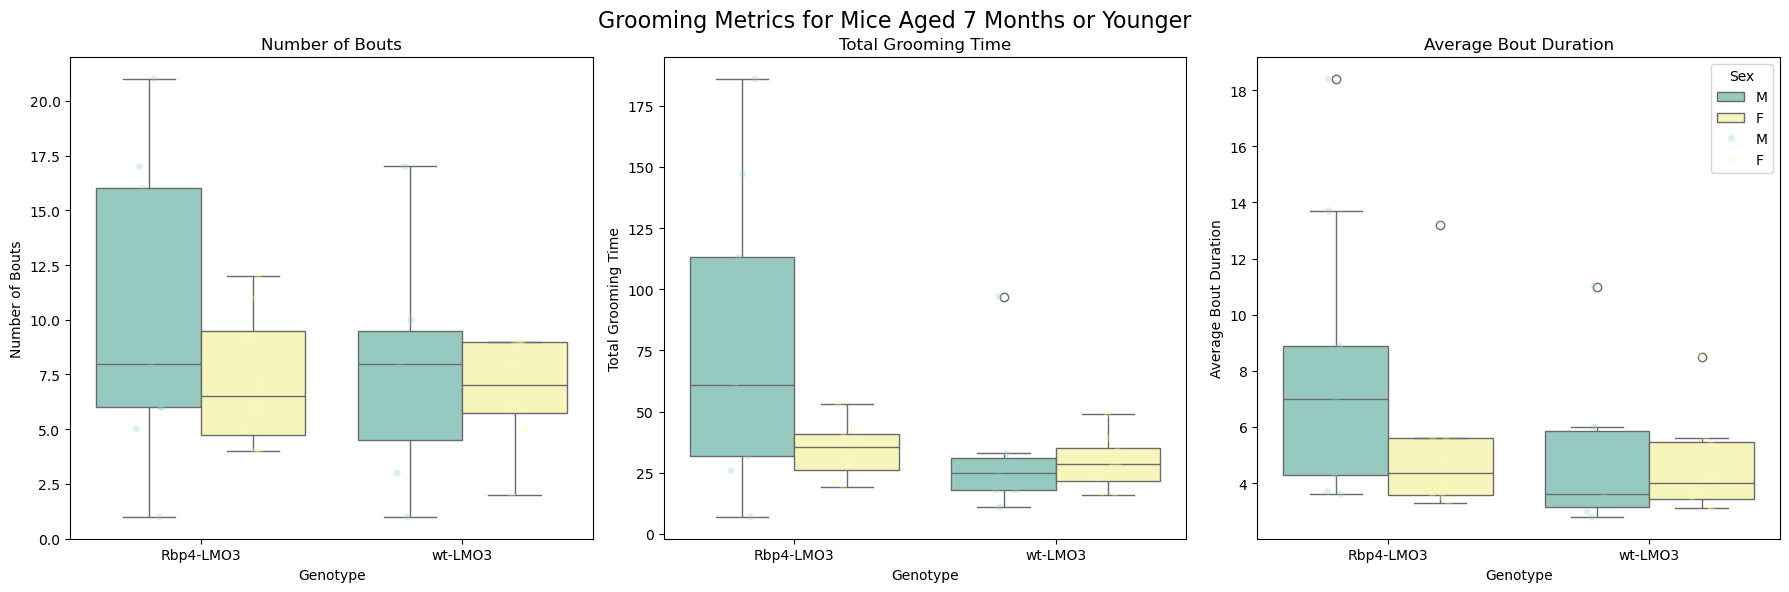

In [122]:
mouse_analysis_grooming.plot_metrics_comparison_boxplot(min_age=7)

Data filtered for mice aged 7 months or younger.
Number of mice in filtered data: 32


/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_54774/1366961531.py:260: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="genotype", y="value",
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_54774/1366961531.py:264: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x="genotype", y="value",
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_54774/1366961531.py:260: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="genotype", y="value",
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_54774/1366961531.py:2

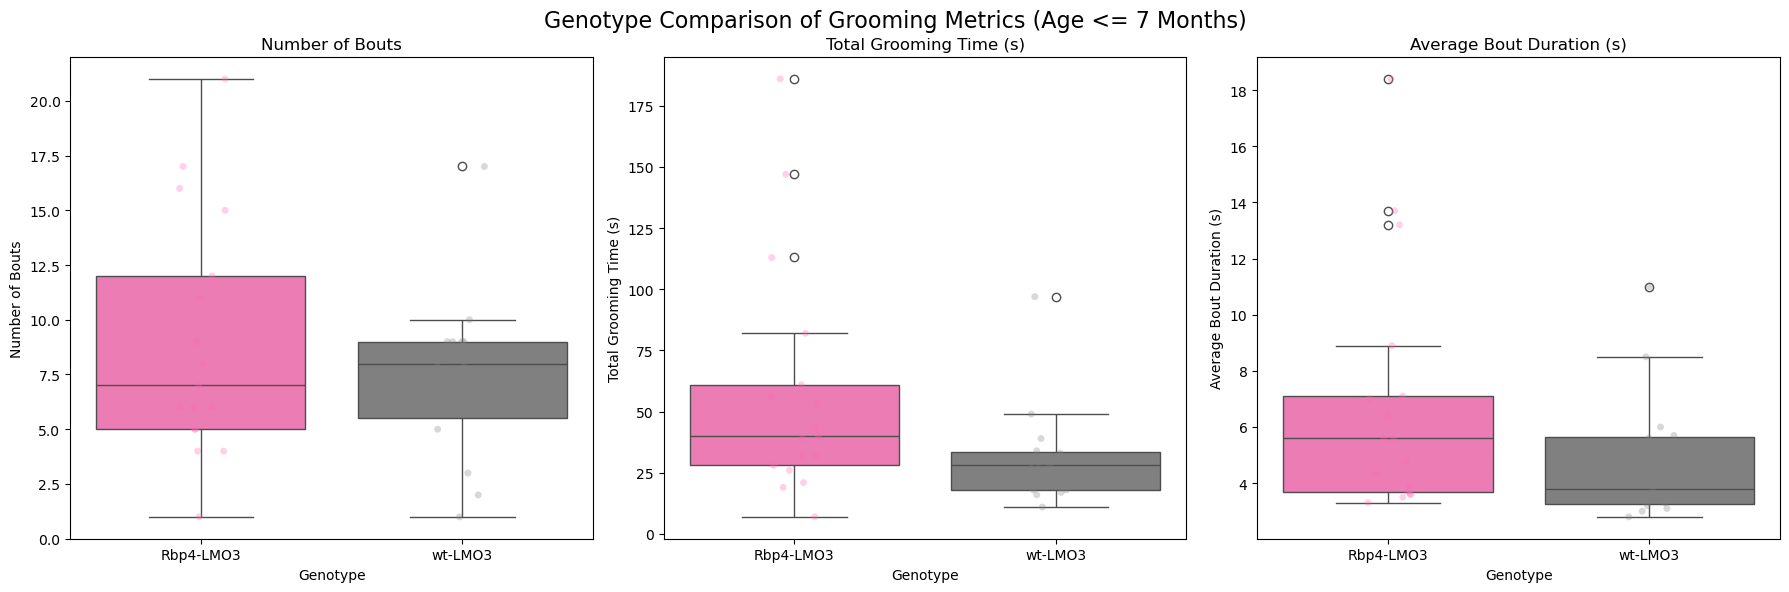

In [123]:
mouse_analysis_grooming.plot_genotype_comparison(min_age=7)

In [124]:
stats_results = mouse_analysis_grooming.compare_genotypes_statistically(min_age=7)  # Compare mice 3 months or younger

Data filtered for mice aged 7 months or younger.
Number of mice in filtered data: 32

Statistical comparison for mice aged 7 months or younger:
 Metric  T-test p-value  Mann-Whitney U p-value  N (Rbp4-LMO3)  N (wt-LMO3)
  bouts        0.299333                0.608015             17           15
    sum        0.055915                0.034372             17           15
average        0.119715                0.075654             17           15


In [125]:
anova_results = mouse_analysis_grooming.analyze_sex_effect(min_age=7)  # Analyze mice 3 months or younger

Data filtered for mice aged 7 months or younger.
Number of mice in filtered data: 32

Two-way ANOVA results for mice aged 7 months or younger:
 Metric  Genotype p-value  Sex p-value  Interaction p-value
  bouts          0.337654     0.204410             0.497528
    sum          0.054304     0.053212             0.115544
average          0.136954     0.206257             0.366769


In [114]:
mouse_analysis_grooming.analyze_genotype_sex_effects_nonparametric(min_age=7)  # Analyze mice 3 months or younger

Data filtered for mice aged 7 months or older.
Number of mice in filtered data: 20

Non-parametric test results for mice aged 7 months or older:
 Metric  Genotype p-value  Sex p-value  N (Rbp4-LMO3)  N (wt-LMO3)
  bouts          0.702548     0.120849             11            9
    sum          0.237898     0.615231             11            9
average          0.055554     0.161566             11            9


,Metric,Genotype p-value,Sex p-value,N (Rbp4-LMO3),N (wt-LMO3)
0,bouts,0.702548,0.120849,11,9
1,sum,0.237898,0.615231,11,9
2,average,0.055554,0.161566,11,9


Data filtered for mice aged 7 months or older.
Number of mice in filtered data: 20


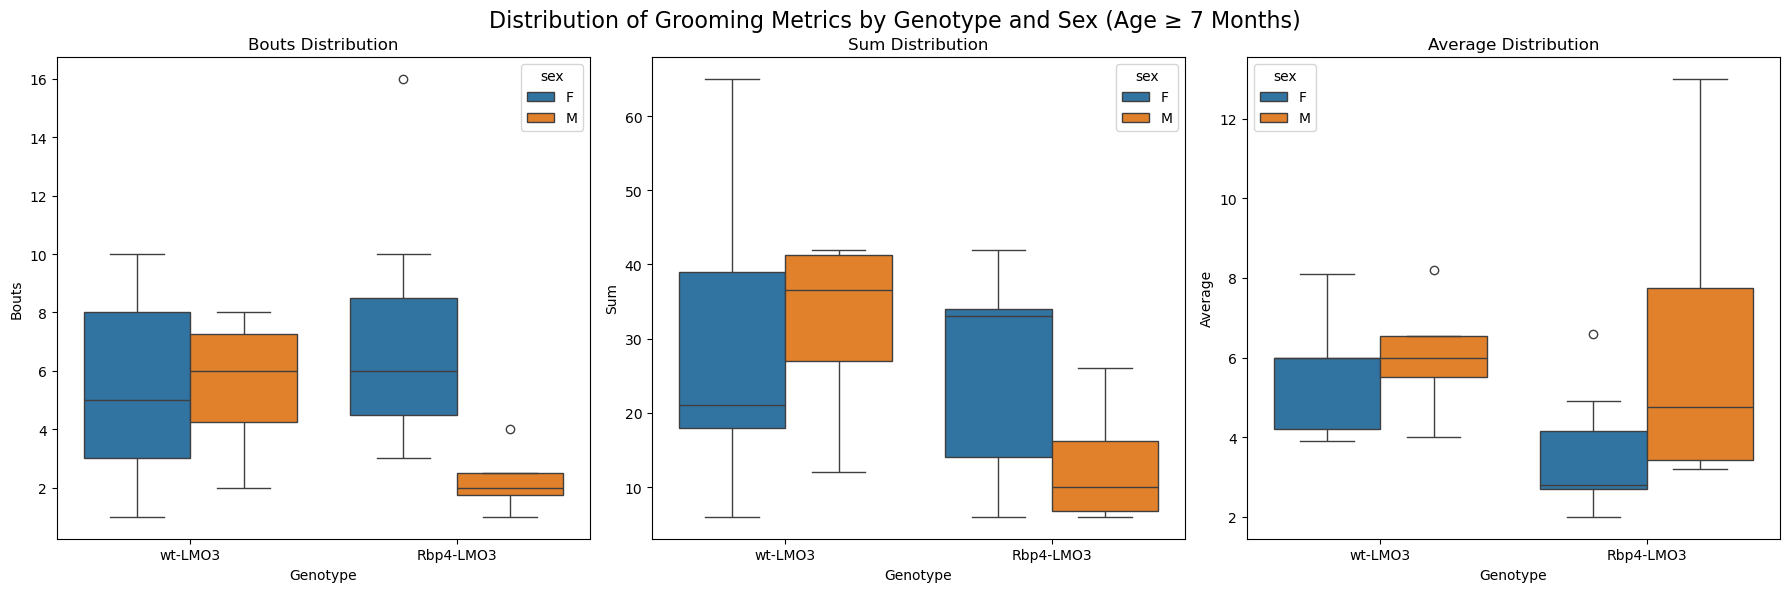

In [115]:
mouse_analysis_grooming.plot_distributions(min_age=7)  # Analyze mice 3 months or younger

In [103]:
mouse_analysis.genotype_nested_df.head()

cohort   tag  toe sex   dam        DOB treatment  \
genotype                                                         
Rbp4-LMO3 0        3  3427    3   M  3244 2023-06-10       CTZ   
          3        4  3435    3  M   3426 2023-06-20       CTZ   
          7        6  3515    3   M  3377 2023-08-10       CTZ   
          10       6  3518    4   M  3377 2023-08-10       CTZ   
          11       7  3522    2   M  3378 2023-08-14       CTZ   

              interactiontime_sum_familiar  interactiontime_sum_stranger  \
genotype                                                                   
Rbp4-LMO3 0                             26                            42   
          3                             12                            36   
          7                             10                             0   
          10                            22                            17   
          11                            27                             1   

              interactiontime_avg_familiar  interactiontime_avg_stranger  \
genotype                                                                   
Rbp4-LMO3 0                       2.600000                      4.666667   
          3                       2.400000                      7.200000   
          7                       2.000000                      0.000000   
          10                      2.444444                      6.000000   
          11                      2.454545                      1.000000   

              approach_sum_familiar  approach_sum_stranger datetested  \
genotype                                                                
Rbp4-LMO3 0                      10               9.000000 2023-11-29   
          3                       5               5.000000 2024-05-08   
          7                       5               0.000000 2024-06-03   
          10                      9               2.833333 2024-06-03   
          11                     11               1.000000 2024-06-04   

              age_in_months  
genotype                     
Rbp4-LMO3 0            5.65  
          3           10.61  
          7            9.79  
          10           9.79  
          11           9.69

In [104]:
mouse_analysis.genotype_sex_groups.head()

cohort   tag  toe   dam        DOB treatment  \
genotype  sex                                                    
Rbp4-LMO3 F   22       3  3440    1  3244 2023-06-10       CTZ   
              23       4  3437    9  3246 2023-06-20       CTZ   
              25       4  3439    7  3246 2023-06-20       CTZ   
              28       6  3520    7  3377 2023-08-10       CTZ   
              31       7  3525    1  3378 2023-08-14       CTZ   

                  interactiontime_sum_familiar  interactiontime_sum_stranger  \
genotype  sex                                                                  
Rbp4-LMO3 F   22                            13                            15   
              23                            12                            14   
              25                            22                            34   
              28                            19                            25   
              31                            21                            16   

                  interactiontime_avg_familiar  interactiontime_avg_stranger  \
genotype  sex                                                                  
Rbp4-LMO3 F   22                      4.333333                      3.750000   
              23                      2.400000                      2.800000   
              25                      2.750000                      3.400000   
              28                      2.375000                      2.083333   
              31                      1.909091                      3.200000   

                  approach_sum_familiar  approach_sum_stranger datetested  \
genotype  sex                                                               
Rbp4-LMO3 F   22                      3                    4.0 2024-03-28   
              23                      5                    5.0 2024-05-07   
              25                      8                   10.0 2024-05-07   
              28                      8                   12.0 2024-05-28   
              31                     11                    5.0 2024-07-02   

                  age_in_months  
genotype  sex                    
Rbp4-LMO3 F   22           9.59  
              23          10.58  
              25          10.58  
              28           9.59  
              31          10.61

In [105]:
mouse_analysis.analysis.compare_genotypes()

Paired metrics: [('interactiontime_sum_familiar', 'interactiontime_sum_stranger'), ('interactiontime_avg_familiar', 'interactiontime_avg_stranger'), ('approach_sum_familiar', 'approach_sum_stranger')]
Genotypes: Rbp4-LMO3, wt-LMO3
Processing genotype: Rbp4-LMO3
Metrics: interactiontime_sum_familiar vs interactiontime_sum_stranger
Data shape for Rbp4-LMO3: (23, 15)
Columns in data: Index(['cohort', 'tag', 'toe', 'sex', 'dam', 'DOB', 'treatment',
       'interactiontime_sum_familiar', 'interactiontime_sum_stranger',
       'interactiontime_avg_familiar', 'interactiontime_avg_stranger',
       'approach_sum_familiar', 'approach_sum_stranger', 'datetested',
       'age_in_months'],
      dtype='object')
Familiar data: 0     26
3     12
7     10
10    22
11    27
Name: interactiontime_sum_familiar, dtype: int64
Stranger data: 0     42
3     36
7      0
10    17
11     1
Name: interactiontime_sum_stranger, dtype: int64
t-statistic: -0.786834341049485, p-value: 0.4397732267324479
Processing g

,genotype,familiar_metric,stranger_metric,t_statistic,p_value
0,Rbp4-LMO3,interactiontime_sum_familiar,interactiontime_sum_stranger,-0.786834,0.439773
1,wt-LMO3,interactiontime_sum_familiar,interactiontime_sum_stranger,-0.454879,0.653653
2,Rbp4-LMO3,interactiontime_avg_familiar,interactiontime_avg_stranger,-1.782366,0.088497
3,wt-LMO3,interactiontime_avg_familiar,interactiontime_avg_stranger,0.546735,0.590064
4,Rbp4-LMO3,approach_sum_familiar,approach_sum_stranger,0.482840,0.633979
5,wt-LMO3,approach_sum_familiar,approach_sum_stranger,-1.426808,0.167674


In [562]:
mouse_analysis.genotype_nested_df

cohort   tag  toe sex   dam        DOB treatment  \
genotype                                                         
Rbp4-LMO3 0        3  3427    3   M  3244 2023-06-10       CTZ   
          3        4  3435    3  M   3426 2023-06-20       CTZ   
          7        6  3515    3   M  3377 2023-08-10       CTZ   
          10       6  3518    4   M  3377 2023-08-10       CTZ   
          11       7  3522    2   M  3378 2023-08-14       CTZ   
          12       7  3523    7   M  3378 2023-08-14       CTZ   
          13       8  3554    4   M  3243 2023-08-28       CTZ   
          15       9  3559    6   M  3377 2023-09-03      CTZ    
          17       9  3561    2   M  3377 2023-09-03      CTZ    
          18      10  3548    1   M  3378 2023-09-08       CTZ   
          22       3  3440    1  F   3244 2023-06-10       CTZ   
          23       4  3437    9  F   3246 2023-06-20       CTZ   
          25       4  3439    7  F   3246 2023-06-20       CTZ   
          28       6  3520    7  F   3377 2023-08-10       CTZ   
          31       7  3525    1  F   3378 2023-08-14       CTZ   
          32       7  3551    5  F   3378 2023-08-14       CTZ   
          33       7  3552    3  F   3378 2023-08-14       CTZ   
          36       8  3557    6  F   3243 2023-08-28       CTZ   
          38       9  3562    7  F   3377 2023-09-03       CTZ   
          40       9  3564    5  F   3377 2023-09-03      CTZ    
          41       9  3565    3  F   3377 2023-09-03       CTZ   
          43      10  2809    2  F   3378 2023-09-08       CTZ   
          45      10  2839    4  F   3378 2023-09-08       CTZ   
wt-LMO3   1        3  3428    4   M  3244 2023-06-10       CTZ   
          2        4  3434    4   M  3246 2023-06-20       CTZ   
          4        4  3436    1   M  3246 2023-06-20       CTZ   
          5        5  3442    2   M  3426 2023-07-14      CTZ    
          6        6  3514    2   M  3377 2023-08-10       CTZ   
          8        6  3516    8   M  3377 2023-08-10       CTZ   
          9        6  3517    1   M  3377 2023-08-10       CTZ   
          14       8  3555    3   M  3243 2023-08-28       CTZ   
          16       9  3560    1   M  3377 2023-09-03      CTZ    
          19      10  3549    8   M  3378 2023-09-08      CTZ    
          20      10  3550    5   M  3378 2023-09-08      CTZ    
          21       3  3429    2  F   3244 2023-06-10       CTZ   
          24       4  3438    6  F   3246 2023-06-20      CTZ    
          26       5  3445    4  F   3246 2023-07-14       CTZ   
          27       6  3519    6  F   3377 2023-08-10       CTZ   
          29       6  3521    5  F   3377 2023-08-10       CTZ   
          30       7  3524    8  F   3378 2023-08-14       CTZ   
          34       7  3553    6  F   3378 2023-08-14       CTZ   
          35       8  3556    7  F   3243 2023-08-28       CTZ   
          37       8  3558    5  F   3243 2023-08-28      CTZ    
          39       9  3563    4  F   3377 2023-09-03       CTZ   
          42      10  2808    7  F   3378 2023-09-08       CTZ   
          44      10  2838    6  F   3378 2023-09-08       CTZ   

              interactiontime_sum_familiar  interactiontime_sum_stranger  \
genotype                                                                   
Rbp4-LMO3 0                             26                            42   
          3                             12                            36   
          7                             10                             0   
          10                            22                            17   
          11                            27                             1   
          12                             0                            15   
          13                            10                            15   
          15                            36                             5   
          17                             8                            40   
         

In [563]:
mouse_analysis.analysis.genotype_results

,genotype,familiar_metric,stranger_metric,t_statistic,p_value
0,Rbp4-LMO3,interactiontime_sum_familiar,interactiontime_sum_stranger,-0.786834,0.439773
1,wt-LMO3,interactiontime_sum_familiar,interactiontime_sum_stranger,-0.454879,0.653653
2,Rbp4-LMO3,interactiontime_avg_familiar,interactiontime_avg_stranger,-1.782366,0.088497
3,wt-LMO3,interactiontime_avg_familiar,interactiontime_avg_stranger,0.546735,0.590064
4,Rbp4-LMO3,approach_sum_familiar,approach_sum_stranger,0.482840,0.633979
5,wt-LMO3,approach_sum_familiar,approach_sum_stranger,-1.426808,0.167674


Paired metrics: [('interactiontime_sum_familiar', 'interactiontime_sum_stranger'), ('interactiontime_avg_familiar', 'interactiontime_avg_stranger'), ('approach_sum_familiar', 'approach_sum_stranger')]
Genotypes: Rbp4-LMO3, wt-LMO3

Checking assumptions for metrics: interactiontime_sum_familiar vs interactiontime_sum_stranger

Processing genotype: Rbp4-LMO3
Shapiro-Wilk test for normality p-value: 0.4931
Levene's test for homogeneity of variances p-value: 0.8693


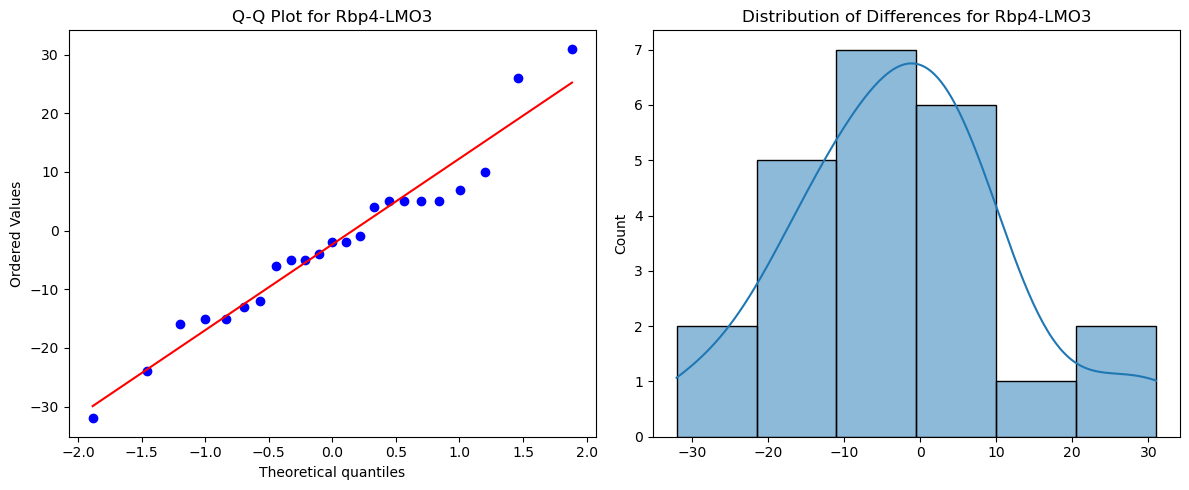


Processing genotype: wt-LMO3
Shapiro-Wilk test for normality p-value: 0.9027
Levene's test for homogeneity of variances p-value: 0.8589


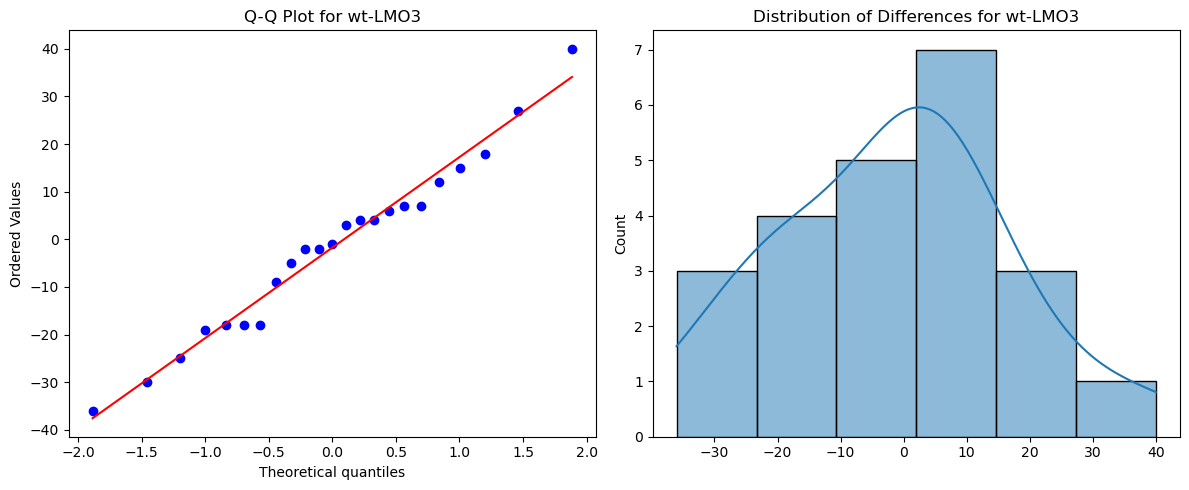


Checking assumptions for metrics: interactiontime_avg_familiar vs interactiontime_avg_stranger

Processing genotype: Rbp4-LMO3
Shapiro-Wilk test for normality p-value: 0.9236
Levene's test for homogeneity of variances p-value: 0.2036


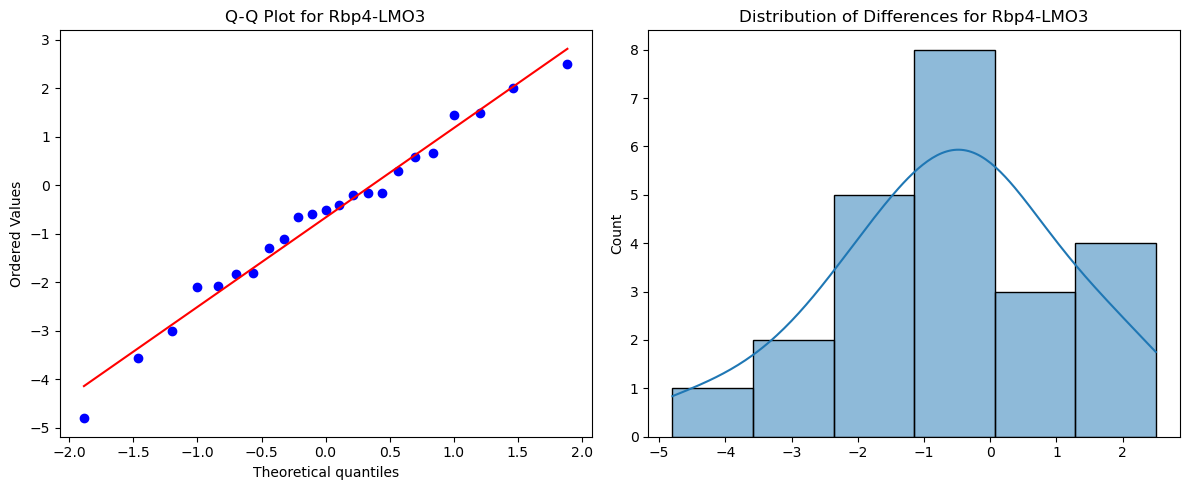


Processing genotype: wt-LMO3
Shapiro-Wilk test for normality p-value: 0.0589
Levene's test for homogeneity of variances p-value: 0.9198


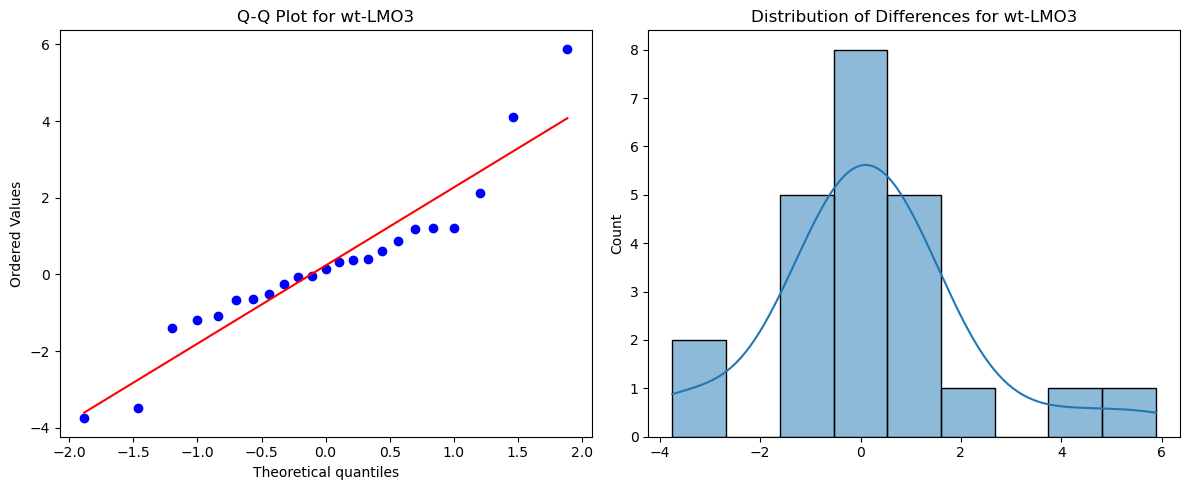


Checking assumptions for metrics: approach_sum_familiar vs approach_sum_stranger

Processing genotype: Rbp4-LMO3
Shapiro-Wilk test for normality p-value: 0.3539
Levene's test for homogeneity of variances p-value: 0.3953


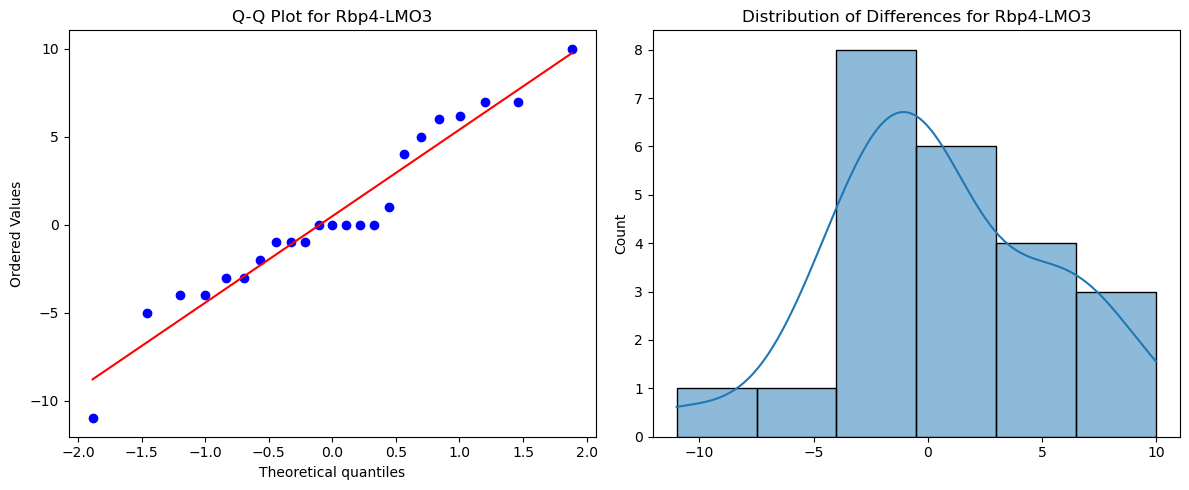


Processing genotype: wt-LMO3
Shapiro-Wilk test for normality p-value: 0.0368
Levene's test for homogeneity of variances p-value: 0.2808


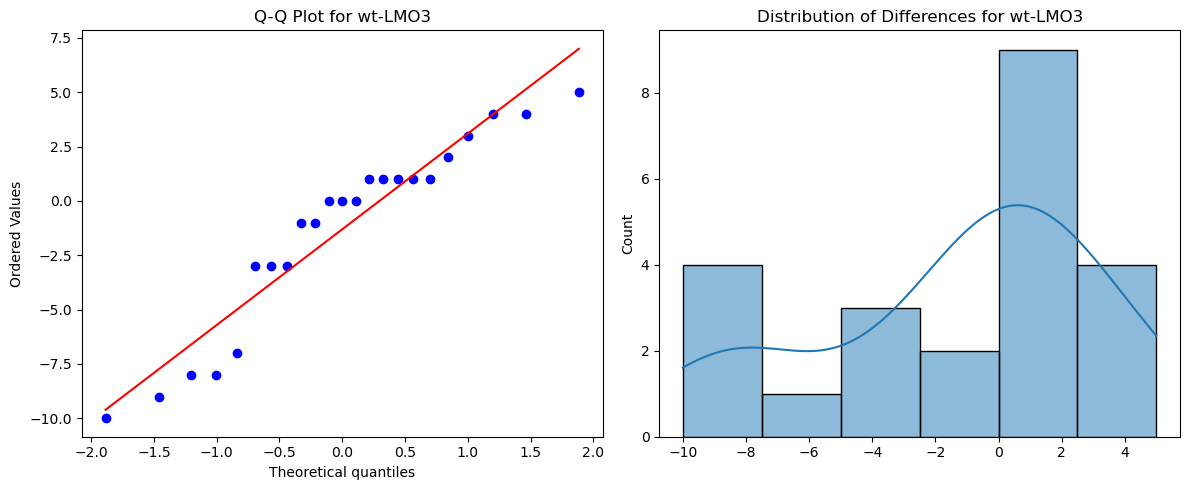


Assumption check results:
    genotype                                        metric_pair  \
0  Rbp4-LMO3  interactiontime_sum_familiar vs interactiontim...   
1    wt-LMO3  interactiontime_sum_familiar vs interactiontim...   
2  Rbp4-LMO3  interactiontime_avg_familiar vs interactiontim...   
3    wt-LMO3  interactiontime_avg_familiar vs interactiontim...   
4  Rbp4-LMO3     approach_sum_familiar vs approach_sum_stranger   
5    wt-LMO3     approach_sum_familiar vs approach_sum_stranger   

   normality_p_value  homogeneity_p_value  
0           0.493073             0.869252  
1           0.902746             0.858867  
2           0.923586             0.203619  
3           0.058884             0.919790  
4           0.353934             0.395309  
5           0.036758             0.280783  


,genotype,metric_pair,normality_p_value,homogeneity_p_value
0,Rbp4-LMO3,interactiontime_sum_familiar vs interactiontim...,0.493073,0.869252
1,wt-LMO3,interactiontime_sum_familiar vs interactiontim...,0.902746,0.858867
2,Rbp4-LMO3,interactiontime_avg_familiar vs interactiontim...,0.923586,0.203619
3,wt-LMO3,interactiontime_avg_familiar vs interactiontim...,0.058884,0.919790
4,Rbp4-LMO3,approach_sum_familiar vs approach_sum_stranger,0.353934,0.395309
5,wt-LMO3,approach_sum_familiar vs approach_sum_stranger,0.036758,0.280783


In [564]:
mouse_analysis.analysis.check_assumptions()

In [565]:
# Create and show the interactive plot
mouse_analysis.analysis.show_interactive_plot()

In [566]:
# Calculate the discrimination metric
mouse_analysis.analysis.calculate_discrimination_metric()

# Show the interactive discrimination plot
mouse_analysis.analysis.show_discrimination_plot()

In [567]:
# Perform t-tests on the discrimination index
mouse_analysis.analysis.perform_discrimination_ttest()

,Metric Pair,t-statistic,p-value
0,interactiontime_sum_familiar vs interactiontim...,0.064349,0.948984
1,interactiontime_avg_familiar vs interactiontim...,1.204622,0.234789
2,approach_sum_familiar vs approach_sum_stranger,-0.888604,0.379048


In [568]:
mouse_analysis.genotype_sex_groups

cohort   tag  toe   dam        DOB treatment  \
genotype  sex                                                    
Rbp4-LMO3 F   22       3  3440    1  3244 2023-06-10       CTZ   
              23       4  3437    9  3246 2023-06-20       CTZ   
              25       4  3439    7  3246 2023-06-20       CTZ   
              28       6  3520    7  3377 2023-08-10       CTZ   
              31       7  3525    1  3378 2023-08-14       CTZ   
              32       7  3551    5  3378 2023-08-14       CTZ   
              33       7  3552    3  3378 2023-08-14       CTZ   
              36       8  3557    6  3243 2023-08-28       CTZ   
              38       9  3562    7  3377 2023-09-03       CTZ   
              40       9  3564    5  3377 2023-09-03      CTZ    
              41       9  3565    3  3377 2023-09-03       CTZ   
              43      10  2809    2  3378 2023-09-08       CTZ   
              45      10  2839    4  3378 2023-09-08       CTZ   
          M   0        3  3427    3  3244 2023-06-10       CTZ   
              7        6  3515    3  3377 2023-08-10       CTZ   
              10       6  3518    4  3377 2023-08-10       CTZ   
              11       7  3522    2  3378 2023-08-14       CTZ   
              12       7  3523    7  3378 2023-08-14       CTZ   
              13       8  3554    4  3243 2023-08-28       CTZ   
              15       9  3559    6  3377 2023-09-03      CTZ    
              17       9  3561    2  3377 2023-09-03      CTZ    
              18      10  3548    1  3378 2023-09-08       CTZ   
          M   3        4  3435    3  3426 2023-06-20       CTZ   
wt-LMO3   F   21       3  3429    2  3244 2023-06-10       CTZ   
              24       4  3438    6  3246 2023-06-20      CTZ    
              26       5  3445    4  3246 2023-07-14       CTZ   
              27       6  3519    6  3377 2023-08-10       CTZ   
              29       6  3521    5  3377 2023-08-10       CTZ   
              30       7  3524    8  3378 2023-08-14       CTZ   
              34       7  3553    6  3378 2023-08-14       CTZ   
              35       8  3556    7  3243 2023-08-28       CTZ   
              37       8  3558    5  3243 2023-08-28      CTZ    
              39       9  3563    4  3377 2023-09-03       CTZ   
              42      10  2808    7  3378 2023-09-08       CTZ   
              44      10  2838    6  3378 2023-09-08       CTZ   
          M   1        3  3428    4  3244 2023-06-10       CTZ   
              2        4  3434    4  3246 2023-06-20       CTZ   
              4        4  3436    1  3246 2023-06-20       CTZ   
              5        5  3442    2  3426 2023-07-14      CTZ    
              6        6  3514    2  3377 2023-08-10       CTZ   
              8        6  3516    8  3377 2023-08-10       CTZ   
              9        6  3517    1  3377 2023-08-10       CTZ   
              14       8  3555    3  3243 2023-08-28       CTZ   
              16       9  3560    1  3377 2023-09-03      CTZ    
              19      10  3549    8  3378 2023-09-08      CTZ    
              20      10  3550    5  3378 2023-09-08      CTZ    

                  interactiontime_sum_familiar  interactiontime_sum_stranger  \
genotype  sex                                                                  
Rbp4-LMO3 F   22                            13                            15   
              23                            12                            14   
              25                            22                            34   
              28                            19                            25   
              31                            21                            16   
              32                            21                            16   
              33                             1                            14   
              36                             5                             9   
              38                            19   

In [569]:
mouse_analysis.analysis.inspect_genotype_sex_groups()

Type of genotype_sex_groups: <class 'pandas.core.frame.DataFrame'>
Keys in genotype_sex_groups:
cohort
tag
toe
dam
DOB
treatment
interactiontime_sum_familiar
interactiontime_sum_stranger
interactiontime_avg_familiar
interactiontime_avg_stranger
approach_sum_familiar
approach_sum_stranger
datetested
age_in_months

Sample of first group:
genotype   sex    
Rbp4-LMO3  F    22    3
                23    4
                25    4
                28    6
                31    7
Name: cohort, dtype: int64


In [570]:
# Calculate the sex-dependent discrimination metric
mouse_analysis.analysis.calculate_sex_dependent_discrimination_metric()

# Perform t-tests on the sex-dependent discrimination index
mouse_analysis.analysis.perform_sex_dependent_discrimination_ttest()

mouse_analysis.analysis.discrimination_ttest_results

# Show the interactive sex-dependent discrimination plot
mouse_analysis.analysis.show_sex_dependent_discrimination_plot()


Processing group: Genotype = Rbp4-LMO3, Sex = F 
  Mouse 3440: Discrimination = 0.0714
  Mouse 3437: Discrimination = 0.0769
  Mouse 3439: Discrimination = 0.2143
  Mouse 3520: Discrimination = 0.1364
  Mouse 3525: Discrimination = -0.1351
  Mouse 3551: Discrimination = -0.1351
  Mouse 3552: Discrimination = 0.8667
  Mouse 3557: Discrimination = 0.2857
  Mouse 3562: Discrimination = -0.1176
  Mouse 3564: Discrimination = 0.6522
  Mouse 3565: Discrimination = -0.2414
  Mouse 2809: Discrimination = -0.4545
  Mouse 2839: Discrimination = 0.3846
  Mouse 3440: Discrimination = -0.0722
  Mouse 3437: Discrimination = 0.0769
  Mouse 3439: Discrimination = 0.1057
  Mouse 3520: Discrimination = -0.0654
  Mouse 3525: Discrimination = 0.2527
  Mouse 3551: Discrimination = 0.3538
  Mouse 3552: Discrimination = 0.4737
  Mouse 3557: Discrimination = 0.1489
  Mouse 3562: Discrimination = -0.1176
  Mouse 3564: Discrimination = 0.4074
  Mouse 3565: Discrimination = 0.1756
  Mouse 2809: Discrimination =

In [571]:
mouse_analysis.analysis.discrimination_ttest_results

,Metric Pair,Comparison,t-statistic,p-value
0,interactiontime_sum_familiar vs interactiontim...,Rbp4-LMO3 vs wt-LMO3,0.064349,0.948984
1,interactiontime_sum_familiar vs interactiontim...,Rbp4-LMO3: Male vs Female,NaN,NaN
2,interactiontime_sum_familiar vs interactiontim...,wt-LMO3: Male vs Female,NaN,NaN
3,interactiontime_avg_familiar vs interactiontim...,Rbp4-LMO3 vs wt-LMO3,1.204622,0.234789
4,interactiontime_avg_familiar vs interactiontim...,Rbp4-LMO3: Male vs Female,NaN,NaN
5,interactiontime_avg_familiar vs interactiontim...,wt-LMO3: Male vs Female,NaN,NaN
6,approach_sum_familiar vs approach_sum_stranger,Rbp4-LMO3 vs wt-LMO3,-0.888604,0.379048
7,approach_sum_familiar vs approach_sum_stranger,Rbp4-LMO3: Male vs Female,NaN,NaN
8,approach_sum_familiar vs approach_sum_stranger,wt-LMO3: Male vs Female,NaN,NaN


In [572]:
# Prepare the metric pair data
mouse_analysis.analysis.prepare_metric_pair_data()

# Show the sex-based metric pair plot
mouse_analysis.analysis.show_sex_based_metric_pair_plot()